# Filter the points outside of the ROI

In [109]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

## Constants

In [111]:
DATA_DIR_ROOT = '../data'
VEL_POINTS_DIR = 'velodyne_points'
LABEL_FILTERED_POINTS = 'label_filtered_points'
LABEL_DIR = 'pillar_pred_format_labels'

In [112]:
def point_is_in_an_roi_box(point, roi_box_list):
    # Extract the point coordinates
    x, y, z = point
    
    for bbox in roi_box_list:
        # Extract the box parameters
        # dz, dy, dx, cx, cy, cz, yaw = bbox
        cx, cy, cz, dx, dy, dz, yaw = bbox
        
        
        # Create the rotation matrix for the yaw angle
        cos_yaw = np.cos(-yaw)  # Negative for the inverse rotation
        sin_yaw = np.sin(-yaw)
        
        rotation_matrix = np.array([
            [cos_yaw, -sin_yaw, 0],
            [sin_yaw,  cos_yaw, 0],
            [0,       0,       1]
        ])
        
        # Translate the point to the box's coordinate frame
        translated_point = np.array([x - cx, y - cy, z - cz])
        
        # Rotate the point to align with the box
        rotated_point = rotation_matrix.dot(translated_point)
        
        # Check if the point is within the box dimensions
        half_lengths = [dz / 2, dy / 2, dx / 2]
        in_box = all([
            -half_lengths[i] <= rotated_point[i] <= half_lengths[i] for i in range(3)
        ])
    
        if in_box:
            return True
    
    return False

In [113]:
def get_roi_boxes(label_file):
    bboxes = []
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location            
            bboxes.append(bbox)
    return np.array(bboxes)

In [114]:
def convert_to_dataframe(bin_path):
    pre_filtered_data = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4) 
    columns = ['x', 'y', 'z', 'intensity']
    df = pd.DataFrame(pre_filtered_data, columns=columns)
    return df

In [115]:
def roi_filter_points(input_file, label_file):
    # Get dataframe from input file
    input_df = convert_to_dataframe(input_file)
    list_roi_boxes = get_roi_boxes(label_file)
    # print(list_roi_boxes)
    
    # Initialize a list to store rows that meet the criteria
    filtered_data = []

    # Iterate through each row in the input DataFrame
    # for index, row in input_df.iterrows():
    for index, row in input_df.iloc[:1000].iterrows():
        point = (row['x'], row['y'], row['z'])
        # Check if the point is inside any of the ROI boxes
        if point_is_in_an_roi_box(point, list_roi_boxes):
            filtered_data.append(row)
        

    # Create a DataFrame from the filtered data
    filtered_df = pd.DataFrame(filtered_data)
    return filtered_df

In [116]:
def save_as_binary(df, bin_path):
    if df.empty:
        return
    # Ensure the DataFrame is in the correct order and data type
    data = df[['x', 'y', 'z', 'intensity']].astype(np.float32).values
    
    # Write the data to a binary file
    data.tofile(bin_path)

In [117]:
def process_points():
    # Make new folder for filtered frames
    new_save_location = Path(DATA_DIR_ROOT, LABEL_FILTERED_POINTS)
    new_save_location.mkdir(exist_ok=True)

    # Original frame path
    lidar_dir = Path(DATA_DIR_ROOT, VEL_POINTS_DIR)
    label_dir = Path(DATA_DIR_ROOT, LABEL_DIR)
    
    # Get just the file names
    files = [f for f in os.listdir(lidar_dir) if f.endswith('.bin')]
    # For each file
    # for filename in files[:3]:
    for filename in files:
        print('.', end='')
        # Append file name to location
        from_file = Path(lidar_dir, filename)
        label_file = Path(label_dir, filename[:-4] + '.txt')

        # Filter file
        # SEND BOTH BIN AND LABELS
        roi_filtered_df = roi_filter_points(from_file, label_file)

        # APPEND FILE NAME TO NEW LOCATION
        to_file = Path(new_save_location, filename)

        # CONVERT BACK TO BINARY and save
        save_as_binary(roi_filtered_df, to_file)

    print()

### Visualize points inside and outside of bounding boxes to make sure they will be filtered correctly

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [120]:
frame = '006000'
bin_path = '../data/velodyne_points/' + frame + '.bin'
label_path = '../data/pillar_pred_format_labels/' + frame + '.txt'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [121]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    x, y, z, dx, dy, dz, yaw = bbox

    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [122]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
    return np.array(bboxes)

In [123]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [124]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [125]:
def plot_color_based_on_location(ax, input_file, label_file):
    input_df = convert_to_dataframe(input_file)
    list_roi_boxes = get_roi_boxes(label_file)

    # Initialize lists to hold points inside and outside ROI boxes
    inside_points = []
    outside_points = []

    # Check each point once and assign to the appropriate list
    for index, row in input_df.iterrows():
        point = (row['x'], row['y'], row['z'])
        if point_is_in_an_roi_box(point, list_roi_boxes):
            inside_points.append(point)
        else:
            outside_points.append(point)

    # Convert lists to numpy arrays for faster plotting
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)

    # Plot points inside ROI boxes in red
    if inside_points.size > 0:
        ax.scatter(inside_points[:, 0], inside_points[:, 1], inside_points[:, 2], s=1, c='r', marker=',')
    
    # Plot points outside ROI boxes in blue
    if outside_points.size > 0:
        ax.scatter(outside_points[:, 0], outside_points[:, 1], outside_points[:, 2], s=0.1, c='b', marker=',')


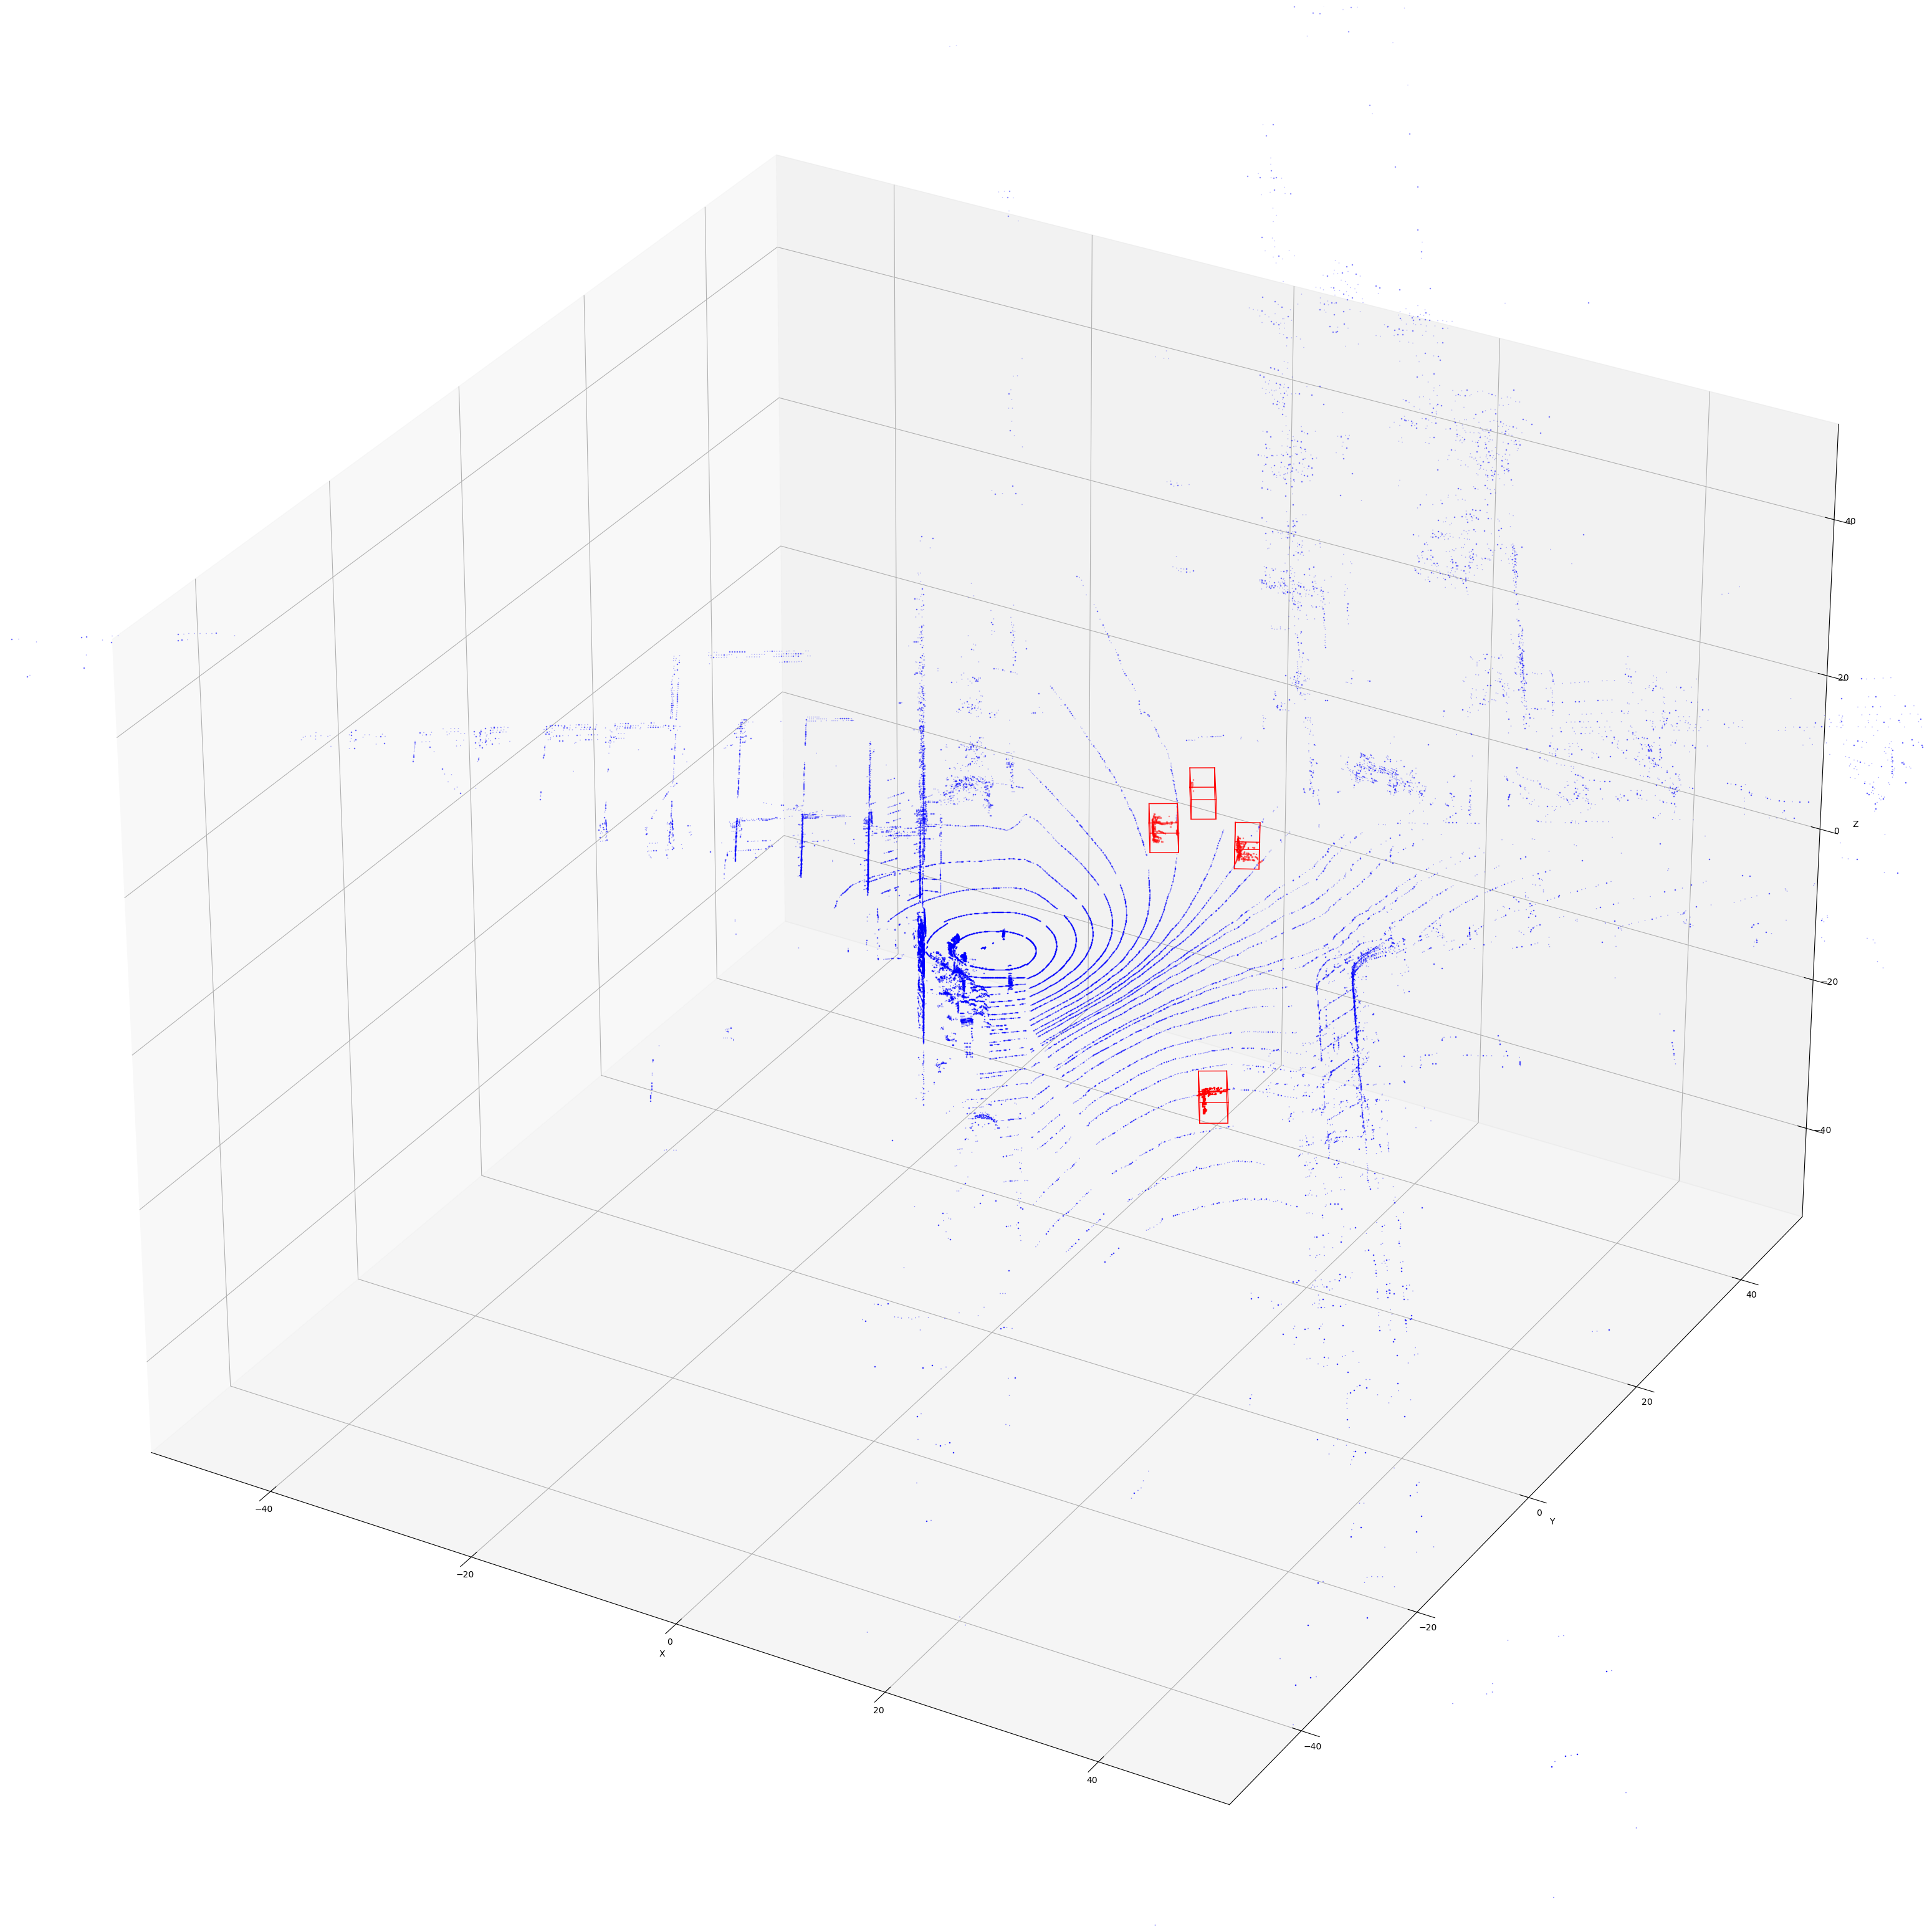

In [126]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')
plot_color_based_on_location(ax, bin_path, label_path)

score_threshold = 0.0
            
# Plot ground truth
for bbox in read_kitti_labels(label_path):
    plot_bbox(ax, bbox, 'r')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

In [127]:
process_points()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................